In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, cross_val_predict, cross_val_score, RepeatedKFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
import lightgbm as lgb
from sklearn.preprocessing import StandardScaler

In [2]:
df = pd.read_csv('../Real_Umbilo.csv', sep=';',decimal=',')
df.set_index('Dia', inplace=True)

df

Q_entrada  NH_entrada  TSS_entrada  DQO_entrada  DBO_entrada  \
Dia                                                                   
0    4719.000000   21.000000   271.000000   391.000000   198.575000   
1    5866.458829   22.000327   276.000327   399.999347   203.059809   
2    5358.157069   23.998870   281.996233   406.995103   206.957307   
3    5266.313109   22.999791   278.000209   401.000418   203.710285   
4    6671.931586   21.000432   274.999568   396.999136   201.824410   
..           ...         ...          ...          ...          ...   
360  5120.341705   20.998558   184.998558   266.997116   135.395000   
361  5587.915779   22.000000   182.001170   263.000000   134.093479   
362  5984.690649   22.998229   179.999646   259.000354   131.495253   
363  8328.225128   19.001002   177.000334   255.999332   129.609978   
364  5364.000000   18.000000   175.000000   251.000000   127.660000   

     TN_entrada  TP_entrada  DQO_saida  Nitrato_saida  Amonia_saida  
Dia                                                                  
0     34.060000    8.020000       33.0           10.8           0.6  
1     35.360294    8.099990       35.0           12.0           0.5  
2     37.558734    8.149966       37.0           14.0           0.5  
3     36.399787    8.109998       39.0           14.0           0.5  
4     34.220441    8.060004       41.0           14.0           0.5  
..          ...         ...        ...            ...           ...  
360   29.898501    6.929986       36.0           12.6           2.1  
361   30.780012    6.900000       36.0           12.8           1.7  
362   31.668215    6.869996       37.0           13.0           1.4  
363   27.521002    6.830000       37.0           25.0           0.5  
364   26.370000    6.790000       37.0           20.0           0.9  

[365 rows x 10 columns]

In [3]:
y = df['DQO_saida']
X = df.drop(['DQO_saida',
            'Nitrato_saida',
            'Amonia_saida',
            'TP_entrada',
            'DQO_entrada',
            'DBO_entrada',], axis=1)

print("X", X.shape)
print("y", y.shape)

X (365, 4)
y (365,)


In [4]:
seed = 42

# separando treino e teste
X_training, X_test, y_training, y_test = train_test_split(X, y, shuffle=False, test_size=0.082) 
print("Test set X", X_test.shape)
print("Test set y", y_test.shape)

Test set X (30, 4)
Test set y (30,)


In [5]:
# Padronização (Standardization) para o y
# Sempre usar os dados de treino apenas para construir o modelo, então transformar o teste com base no treino (como se o teste fossem dados novos)
y_train = np.array(y_training).reshape(len(y_training),1)
y_testing = np.array(y_test).reshape(len(y_test),1)

scalery = StandardScaler().fit(y_train)
normalized_y_train = pd.DataFrame(
    scalery.transform(y_train),
    columns = [y_training.name],
    index = y_training.index
)
normalized_y_train = normalized_y_train.squeeze()

normalized_y_test = pd.DataFrame(
    scalery.transform(y_testing),
    columns = [y_test.name],
    index = y_test.index
)
normalized_y_test = normalized_y_test.squeeze()


# Padronização dos previsores (DataFrame X)
scalerX = StandardScaler().fit(X_training)

normalized_x_train = pd.DataFrame(
    scalerX.transform(X_training),
    columns = X_training.columns,
    index = X_training.index
)


normalized_x_test = pd.DataFrame(
    scalerX.transform(X_test),
    columns = X_test.columns,
    index = X_test.index
)

In [6]:
# Random Forest com validação cruzada e Grid Search

# definindo os valores possíveis dos parâmetros a serem testados
params = {'n_estimators': [1,3,5,10,100,200,400,500],
          'max_depth': [2,3,5,10,15,20],
          'criterion': ['absolute_error','squared_error','poisson'] 
          }

# criando o objeto do modelo com RandomForestRegressor
rf_model_cv_gs = RandomForestRegressor(random_state = seed)

# criando o objeto do grid search com GridSearchCV
grid_search = GridSearchCV(rf_model_cv_gs, param_grid=params, return_train_score=True, scoring='neg_mean_absolute_percentage_error') #neg_root_mean_squared_error

# treinando o modelo com o grid search
grid_search.fit(normalized_x_train, normalized_y_train)

# pegando os resultados da validação cruzada (cv_results)
cv_results = pd.DataFrame(grid_search.cv_results_)

# pegando e imprimindo a melhor combinação de hiperparâmetros
cv_best_params = grid_search.best_params_
print('\n Best hyperparameters:')
print(cv_best_params)



 Best hyperparameters:
{'criterion': 'absolute_error', 'max_depth': 3, 'n_estimators': 400}


In [7]:
# imprimindo o score médio nas bases de treino
print("Average accuracy on train set: {:.3f} +/- {:.3f}".format(cv_results[cv_results.rank_test_score == 1].mean_train_score.values[0],
                                                                     cv_results[cv_results.rank_test_score == 1].std_train_score.values[0])) 
# imprimindo o score médio nas bases de validação
print("Average accuracy on test set: {:.3f} +/- {:.3f}".format(cv_results[cv_results.rank_test_score == 1].mean_test_score.values[0],
                                                                     cv_results[cv_results.rank_test_score == 1].std_test_score.values[0])) 

# configurando o modelo com a melhor combinação de hiperparâmetros
rf_model_cv_gs.set_params(n_estimators = cv_best_params['n_estimators'],
                        max_depth = cv_best_params['max_depth'],
                        )

# treinando um modelo com a melhor combinação de hiperparâmetros
rf_model_cv_gs.fit(normalized_x_train, normalized_y_train)
best_model_params = rf_model_cv_gs.get_params()

Average accuracy on train set: -3.348 +/- 1.502
Average accuracy on test set: -3.229 +/- 2.449


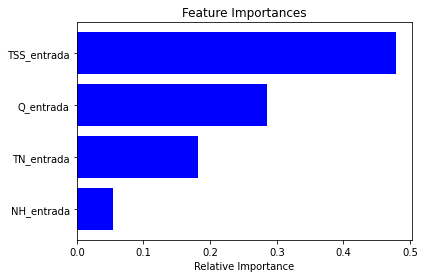

In [8]:
# desenhando o gráfico de impoartância de variáveis
features = normalized_x_train.columns
importances = rf_model_cv_gs.feature_importances_
indices = np.argsort(importances)

feature_importances_df = pd.DataFrame({'features': features,
                                       'importances': importances})

plt.title('Feature Importances')
plt.barh(range(len(importances[indices][-16:])), importances[indices][-16:], color='b', align='center')
plt.yticks(range(len(importances[indices][-16:])), [features[i] for i in indices[-16:]])
plt.xlabel('Relative Importance')
plt.show()

In [9]:
# Informações úteis sobre o melhor modelo
# print(importances)
# print(indices)
# print(importances[indices][-16:])
# print(sum(importances))

# Feature importance em DataFrame para ser mais consumível
df_importances = pd.DataFrame({'feature': features, 'importances': importances})
df_importances.sort_values(by='importances', ascending=False)

feature  importances
2  TSS_entrada     0.478355
0    Q_entrada     0.286036
3   TN_entrada     0.181148
1   NH_entrada     0.054461

In [10]:
# Cross-validation para averiguar precisão do modelo na base de treino
print('---------Treino---------')
results = cross_val_score(rf_model_cv_gs,X=normalized_x_train,y=normalized_y_train,cv=KFold(n_splits=10), scoring='neg_mean_absolute_percentage_error')*(-1)
print(results)
print('Média: {}\nStd: {}'.format(round(results.mean(),4),round(results.std(),4)))
print('---------Total---------')
# Predição analisada por validação cruzada para o dataset inteiro
results_total = cross_val_score(rf_model_cv_gs,X=X,y=y,cv=KFold(n_splits=10), scoring='neg_mean_absolute_percentage_error')*(-1)
print(results_total)
print('Média: {}\nStd: {}'.format(round(results_total.mean(),4),round(results_total.std(),4)))

---------Treino---------
[ 0.76379589 11.24255825  2.56493463  1.92166488  1.1138846   2.6550436
 32.54109285  2.26660553 11.62272915  1.84609315]
Média: 6.8538
Std: 9.372
---------Total---------
[0.5265829  0.28642589 0.19454099 0.16272142 0.31328369 0.26603641
 0.42800251 0.20884535 0.21482904 0.2596382 ]
Média: 0.2861
Std: 0.107


In [11]:
# Realizando a predição no teste
y_test_pred_rf = rf_model_cv_gs.predict(normalized_x_test)

# Desnormalização
y_test_pred_rf = np.array(y_test_pred_rf).reshape(len(y_test_pred_rf),1)
y_test_pred_rf = scalery.inverse_transform(y_test_pred_rf)
y_test_pred_rf = pd.DataFrame(y_test_pred_rf, columns=[normalized_y_test.name], index = normalized_y_test.index)
y_test_pred_rf = y_test_pred_rf.squeeze()

y_test_pred_rf

# Análise dos erros das previsões
rmse_test_rf = math.sqrt(mean_squared_error(y_test, y_test_pred_rf))
mae_test_rf = mean_absolute_error(y_test, y_test_pred_rf)
mape_test_rf = mean_absolute_percentage_error(y_test, y_test_pred_rf)
r2_test_rf = r2_score(y_test, y_test_pred_rf)


df_metricas = pd.DataFrame(data={'RSME':[rmse_test_rf], 'MAE':[mae_test_rf], 'MAPE':[mape_test_rf],'R²':[r2_test_rf]})
df_metricas

RSME        MAE      MAPE        R²
0  21.965677  17.295425  0.288855  0.184769

In [12]:
# Preparação do DataFrame comparativo entre a previsão e o valor real, indexado pelo dia

df_comparacao = pd.concat([y_test,y_test_pred_rf],axis=1)
df_comparacao.columns = ['Valor_Real','Valor_Predito']
df_comparacao['Diferenca_percentual'] = 100*(df_comparacao['Valor_Predito'] - df_comparacao['Valor_Real'])/df_comparacao['Valor_Real']
df_comparacao.sort_index(inplace=True)
df_comparacao

Valor_Real  Valor_Predito  Diferenca_percentual
Dia                                                 
335        75.0      88.417431             17.889909
336        92.0      96.618970              5.020620
337        71.0      98.276862             38.418116
338        59.0      98.281731             66.579205
339        73.0     110.520272             51.397633
340        87.0     112.477220             29.284161
341       101.0     162.972334             61.358747
342       126.0      89.729820            -28.785857
343        60.0      97.293165             62.155275
344        82.0      95.059205             15.925860
345        90.0      96.947541              7.719490
346        93.0      97.172556              4.486620
347        96.0      97.620060              1.687563
348        99.0      98.147774             -0.860834
349        90.0      79.394343            -11.784063
350        81.0      72.789344            -10.136612
351        65.0      74.711459             14.940706
352        81.0      85.345114              5.364338
353        75.0      89.743182             19.657577
354        70.0      87.115631             24.450901
355        64.0      70.166099              9.634529
356        58.0      54.305070             -6.370569
357        35.0      54.202373             54.863922
358        35.0      52.132844             48.950981
359        36.0      52.227666             45.076851
360        36.0      51.445160             42.903222
361        36.0      51.720053             43.666813
362        37.0      52.791851             42.680678
363        37.0      57.294972             54.851276
364        37.0      51.675357             39.663128

        RSME        MAE      MAPE        R²
0  21.965677  17.295425  0.288855  0.184769


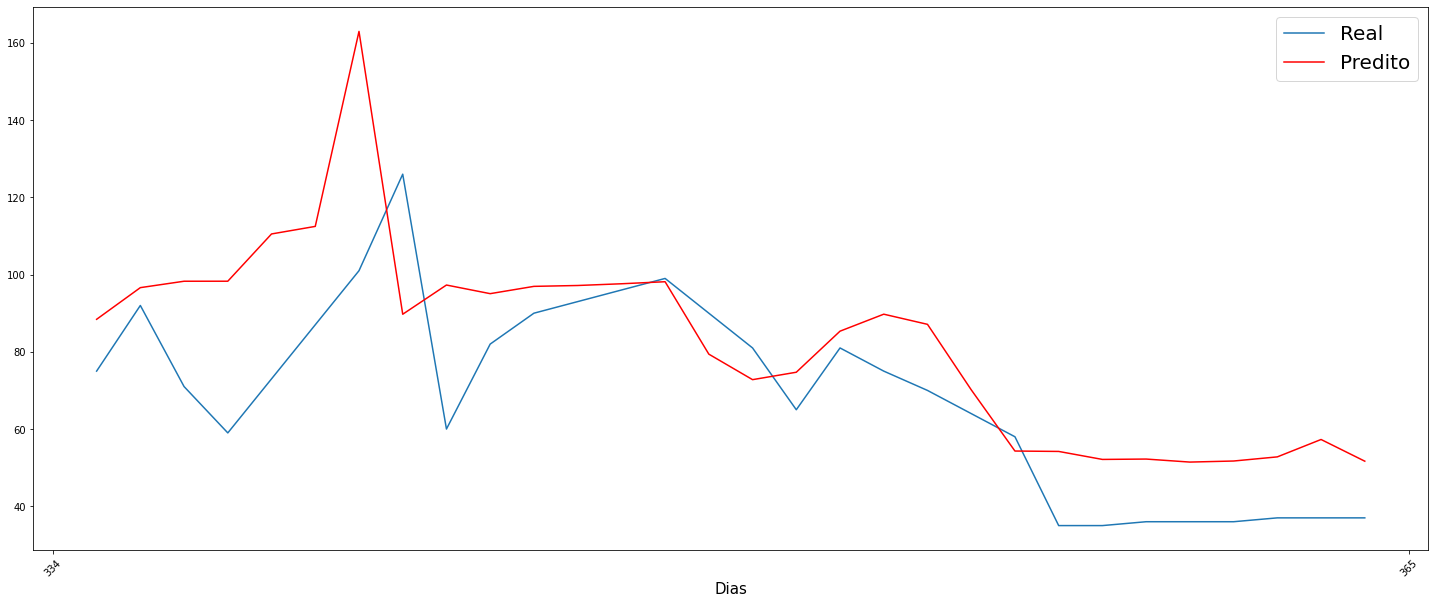

In [13]:
print(df_metricas)
import matplotlib.dates as mdates
# Visualização gráfica das predições comparadas aos valores reais
fig = plt.figure(figsize=(25,10))
ax = fig.add_subplot(1,1,1) 
# plt.title('', fontsize=25)
plt.plot(df_comparacao.index, df_comparacao['Valor_Real'], label = 'Real')
plt.plot(df_comparacao.index, df_comparacao['Valor_Predito'], label = 'Predito', c='r')
plt.legend(fontsize=20)
plt.xlabel('Dias', fontsize=15)
plt.xticks(fontsize=10, rotation=45)

ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1)) 
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%M-%d'))

plt.show()

In [14]:
df_comparacao.to_csv("1_1-Previsoes_RF.csv",encoding='utf-8-sig',sep=';',decimal=',')

# Previsão na base de treino

        RSME        MAE      MAPE        R²
0  32.418198  21.292817  0.236941  0.356629


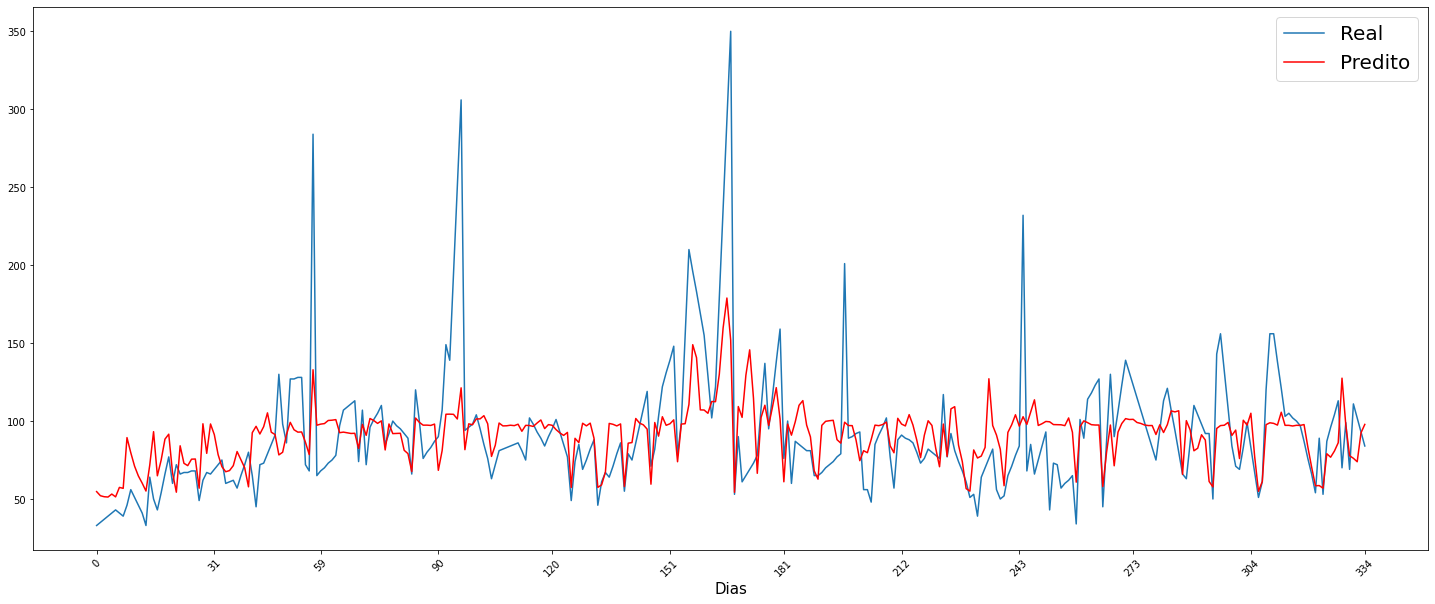

In [15]:
# Realizando a predição no traine
y_train_pred_rf = rf_model_cv_gs.predict(normalized_x_train)

# Desnormalização
y_train_pred_rf = np.array(y_train_pred_rf).reshape(len(y_train_pred_rf),1)
y_train_pred_rf = scalery.inverse_transform(y_train_pred_rf)
y_train_pred_rf = pd.DataFrame(y_train_pred_rf, columns=[normalized_y_train.name], index = normalized_y_train.index)
y_train_pred_rf = y_train_pred_rf.squeeze()

y_train_pred_rf


# Análise dos erros das previsões
rmse_train_rf = math.sqrt(mean_squared_error(y_train, y_train_pred_rf))
mae_train_rf = mean_absolute_error(y_train, y_train_pred_rf)
mape_train_rf = mean_absolute_percentage_error(y_train, y_train_pred_rf)
r2_train_rf = r2_score(y_train, y_train_pred_rf)

# Preparação do DataFrame comparativo entre a previsão e o valor real, indexado pelo dia
df_train_comparacao = pd.concat([y_training,y_train_pred_rf],axis=1)
df_train_comparacao.columns = ['Valor_Real','Valor_Predito']
df_train_comparacao['Diferenca_percentual'] = 100*(df_train_comparacao['Valor_Predito'] - df_train_comparacao['Valor_Real'])/df_train_comparacao['Valor_Real']
df_train_comparacao.sort_index(inplace=True)
df_train_comparacao


df_train_metricas = pd.DataFrame(data={'RSME':[rmse_train_rf], 'MAE':[mae_train_rf], 'MAPE':[mape_train_rf],'R²':[r2_train_rf]})
print(df_train_metricas)

# Visualização gráfica das predições comparadas aos valores reais
fig = plt.figure(figsize=(25,10))
ax = fig.add_subplot(1,1,1) 
# plt.title('', fontsize=25)
plt.plot(df_train_comparacao.index, df_train_comparacao['Valor_Real'], label = 'Real')
plt.plot(df_train_comparacao.index, df_train_comparacao['Valor_Predito'], label = 'Predito', c='r')
plt.legend(fontsize=20)
plt.xlabel('Dias', fontsize=15)
plt.xticks(fontsize=10, rotation=45)

ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1)) 
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%M-%d'))

plt.show()

In [16]:
# Gráfico de cima, queremos os dados só para o melhor modelo (base de treino)
df_train_comparacao.to_csv('2_1-Previsoes_TREINO_RF.csv',sep=';',decimal=',',encoding='utf-8-sig')

# FEATURE IMPORTANCE

## PDPs and Permutation Importance

In [17]:
print(normalized_x_train.min())
print(normalized_x_train.max())

Q_entrada     -2.727095
NH_entrada    -2.605314
TSS_entrada   -2.494750
TN_entrada    -2.588871
dtype: float64
Q_entrada      2.838441
NH_entrada     6.840331
TSS_entrada    4.629701
TN_entrada     4.368140
dtype: float64


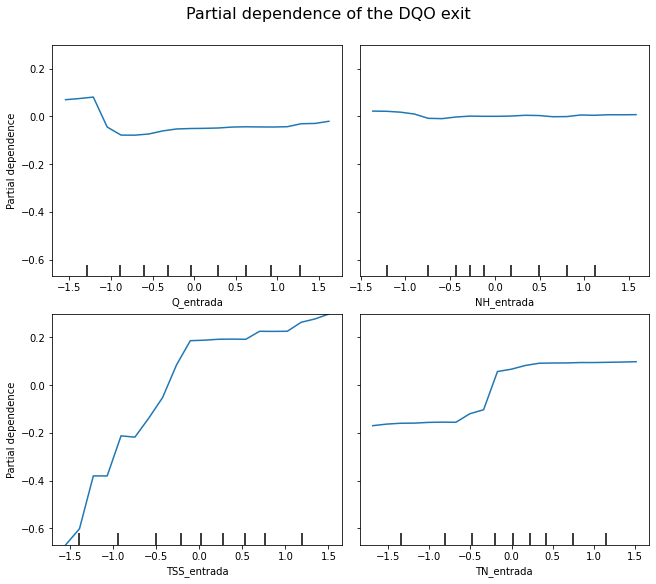

In [18]:
from sklearn.inspection import PartialDependenceDisplay

common_params = {
    "subsample": 50,
    "n_jobs": 2,
    "grid_resolution": 20,
    "random_state": 0,
}

# print("Computing partial dependence plots...")
features_info = {
    # features of interest
    "features": X_training.columns,
    # type of partial dependence plot
    "kind": "average",
    # information regarding categorical features
    # "categorical_features": categorical_features,
}

_, ax = plt.subplots(ncols=2, nrows=2, figsize=(9, 8), constrained_layout=True)
display = PartialDependenceDisplay.from_estimator(
    rf_model_cv_gs,
    normalized_x_train,
    **features_info,
    ax=ax,
    **common_params,
)

_ = display.figure_.suptitle(
    "Partial dependence of the DQO exit\n",
    fontsize=16,
)

Tree-based models provide an alternative measure of feature importances based on the mean decrease in impurity (MDI). Impurity is quantified by the splitting criterion of the decision trees (Gini, Log Loss or Mean Squared Error). However, this method can give high importance to features that may not be predictive on unseen data when the model is overfitting. Permutation-based feature importance, on the other hand, avoids this issue, since it can be computed on unseen data.Furthermore, impurity-based feature importance for trees are strongly biased and favor high cardinality features (typically numerical features) over low cardinality features such as binary features or categorical variables with a small number of possible categories.
Permutation-based feature importances do not exhibit such a bias. Additionally, the permutation feature importance may be computed performance metric on the model predictions and can be used to analyze any model class (not just tree-based models).

Importance_mean  Importance_std  Importance_mean_normalized
TSS_entrada         0.289589        0.052558                    0.530283
Q_entrada           0.148053        0.018786                    0.271109
TN_entrada          0.089942        0.015983                    0.164699
NH_entrada          0.018518        0.002965                    0.033910

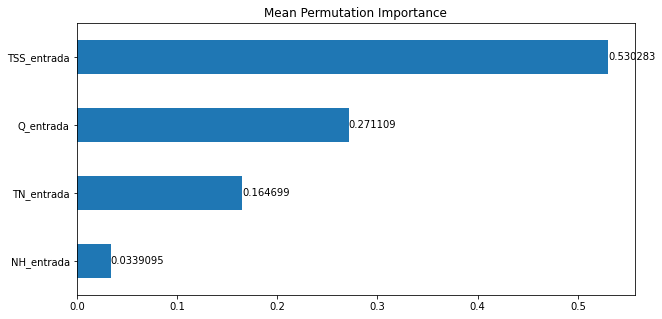

In [19]:
from sklearn.inspection import permutation_importance
r = permutation_importance(rf_model_cv_gs, normalized_x_train, normalized_y_train,
                           n_repeats=30,
                           random_state=0)
# r.importances_mean
# r.importances_std

df_permutation_importance = pd.DataFrame(
    data={'Importance_mean': r.importances_mean,
          'Importance_std': r.importances_std},
    index=normalized_x_train.columns
)

df_permutation_importance['Importance_mean_normalized'] = df_permutation_importance['Importance_mean']/df_permutation_importance['Importance_mean'].sum()

df_permutation_importance = df_permutation_importance.sort_values('Importance_mean',ascending=False)

ax = df_permutation_importance['Importance_mean_normalized'].sort_values(ascending=True).plot.barh(figsize=(10,5), title='Mean Permutation Importance')
ax.bar_label(ax.containers[0])

df_permutation_importance

In [20]:
df_permutation_importance.to_csv('3_1-Permutation_Importance_RF.csv',sep=';',decimal=',',encoding='utf-8-sig')

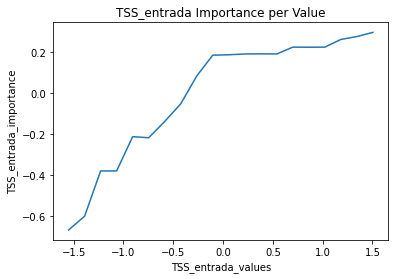

DBO_entrada_importance  Q_entrada_importance  Q_entrada_values  \
0                 0.069965              0.069965         -1.545764   
1                 0.074860              0.074860         -1.379149   
2                 0.080930              0.080930         -1.212533   
3                -0.044631             -0.044631         -1.045917   
4                -0.078399             -0.078399         -0.879302   
5                -0.078703             -0.078703         -0.712686   
6                -0.073826             -0.073826         -0.546070   
7                -0.061004             -0.061004         -0.379454   
8                -0.052748             -0.052748         -0.212839   
9                -0.050847             -0.050847         -0.046223   
10               -0.050081             -0.050081          0.120393   
11               -0.048684             -0.048684          0.287008   
12               -0.044698             -0.044698          0.453624   
13               -0.043550             -0.043550          0.620240   
14               -0.044226             -0.044226          0.786855   
15               -0.044523             -0.044523          0.953471   
16               -0.043215             -0.043215          1.120087   
17               -0.030798             -0.030798          1.286702   
18               -0.029554             -0.029554          1.453318   
19               -0.020512             -0.020512          1.619934   

    NH_entrada_importance  NH_entrada_values  TSS_entrada_importance  \
0                0.022174          -1.365209               -0.669407   
1                0.021409          -1.210232               -0.601893   
2                0.017672          -1.055255               -0.380286   
3                0.009945          -0.900279               -0.380243   
4               -0.008072          -0.745302               -0.212298   
5               -0.009427          -0.590325               -0.217741   
6               -0.002600          -0.435349               -0.138216   
7                0.001121          -0.280372               -0.051700   
8                0.000326          -0.125395                0.084640   
9                0.000337           0.029582                0.186553   
10               0.001449           0.184558                0.188639   
11               0.004630           0.339535                0.192394   
12               0.003593           0.494512                0.193202   
13              -0.001413           0.649488                0.192390   
14              -0.000790           0.804465                0.225954   
15               0.005836           0.959442                0.225503   
16               0.004620           1.114418                0.226036   
17               0.006954           1.269395                0.263654   
18               0.006793           1.424372                0.277730   
19               0.007286           1.579348                0.298415   

    TSS_entrada_values  
0            -1.551337  
1            -1.390468  
2            -1.229599  
3            -1.068730  
4            -0.907861  
5            -0.746992  
6            -0.586123  
7            -0.425254  
8            -0.264385  
9            -0.103516  
10            0.057353  
11            0.218222  
12            0.379091  
13            0.539960  
14            0.700828  
15            0.861697  
16            1.022566  
17            1.183435  
18            1.344304  
19            1.505173

In [21]:
dict_data = {}
df_pdp = pd.DataFrame(display.pd_results[0]['average'].flatten(),columns=[X.columns[0]+'_importance'])
for i in range(len(display.pd_results)):
    dict_data[f"{X.columns[i]}_importance"] = display.pd_results[i]['average']
    dict_data[f"{X.columns[i]}_values"]  = display.pd_results[i]['values']
    # df_pdp[f"{X.columns[i]}_importance"] = dict_data[f"{X.columns[i]}_importance"].flatten()
    df_pdp[f"{X.columns[i]}_importance"] = display.pd_results[i]['average'][0]
    df_pdp[f"{X.columns[i]}_values"] = display.pd_results[i]['values'][0]


plt.plot(df_pdp.loc[:, 'TSS_entrada_values'], df_pdp.loc[:, 'TSS_entrada_importance'])
plt.xlabel('TSS_entrada_values')
plt.ylabel('TSS_entrada_importance')
plt.title('TSS_entrada Importance per Value')
plt.show()


df_pdp.to_csv('4_1-PDPs_RF.csv',encoding='utf-8-sig',decimal=',',sep=';')
df_pdp

In [22]:
# Avaliando na base de TESTE o impacto nas métricas causado pela permutação de valores de cada uma das variáveis.
# https://scikit-learn.org/stable/modules/permutation_importance.html#permutation-importance
scoring = ['r2', 'neg_mean_absolute_percentage_error', 'neg_mean_squared_error']
r_multi = permutation_importance(
    rf_model_cv_gs, normalized_x_test, normalized_y_test, n_repeats=30, random_state=0, scoring=scoring)

# Apenas mostrar as variáveis cujas importâncias são maiores que 2 vezes o respectivo desvio padrão (para todas as métricas)
for metric in r_multi:
    print(f"{metric}")
    r1 = r_multi[metric]
    for i in r1.importances_mean.argsort()[::-1]:
        if r1.importances_mean[i] - 2 * r1.importances_std[i] > 0:
            print(f"    {X.columns[i]}: "
                  f"{r1.importances_mean[i]:.3f}"
                  f" +/- {r1.importances_std[i]:.3f}\n")

r2
    TSS_entrada: 0.804 +/- 0.260

neg_mean_absolute_percentage_error
neg_mean_squared_error
    TSS_entrada: 0.291 +/- 0.094



In [23]:
# Avaliando na base de TREINO o impacto nas métricas causado pela permutação de valores de cada uma das variáveis.
# https://scikit-learn.org/stable/modules/permutation_importance.html#permutation-importance
scoring = ['r2', 'neg_mean_absolute_percentage_error', 'neg_mean_squared_error'] #, 'neg_mean_absolute_error'
r_multi = permutation_importance(
    rf_model_cv_gs, normalized_x_train, normalized_y_train, n_repeats=30, random_state=0, scoring=scoring)

# Apenas mostrar as variáveis cujas importâncias são maiores que 2 vezes o respectivo desvio padrão (para todas as métricas)
for metric in r_multi:
    print(f"{metric}")
    r1 = r_multi[metric]
    for i in r1.importances_mean.argsort()[::-1]:
        if r1.importances_mean[i] - 2 * r1.importances_std[i] > 0:
            print(f"    {X.columns[i]}: "
                  f"{r1.importances_mean[i]:.3f}"
                  f" +/- {r1.importances_std[i]:.3f}")

r2
    TSS_entrada: 0.290 +/- 0.053
    Q_entrada: 0.148 +/- 0.019
    TN_entrada: 0.090 +/- 0.016
    NH_entrada: 0.019 +/- 0.003
neg_mean_absolute_percentage_error
neg_mean_squared_error
    TSS_entrada: 0.290 +/- 0.053
    Q_entrada: 0.148 +/- 0.019
    TN_entrada: 0.090 +/- 0.016
    NH_entrada: 0.019 +/- 0.003


## LIME - Local Interpretable Model-Agnostic Explanations 

In [24]:
import lime
import lime.lime_tabular

# LIME has one explainer for all the models
explainer = lime.lime_tabular.LimeTabularExplainer(normalized_x_train.values, feature_names=X.columns.values.tolist(),
                                                  class_names=[y.name], verbose=True, mode='regression')

### Cálculo da importância de cada variável para um registro específico

In [25]:
# normalized_x_test.iloc[5]
# normalized_x_test.values[5]

# Choose the 5th instance and use it to predict the results
j = 5
exp = explainer.explain_instance(normalized_x_test.iloc[j], rf_model_cv_gs.predict, num_features=4)

# Show the predictions
exp.show_in_notebook(show_table=True)

exp.as_list()

Intercept -0.1487298798904605
Prediction_local [0.51564719]
Right: 0.5317673009864177


c:\Users\hydro\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


[('TSS_entrada > 0.67', 0.3410895190834521),
 ('Q_entrada <= -0.71', 0.2052351233433392),
 ('TN_entrada > 0.54', 0.12363687912371692),
 ('NH_entrada > 0.65', -0.00558445587949659)]

Interpretação: O valor Predito é o central da primeira imagem (Predicted value).
As variáveis à esquerda, tiveram influência negativa para o valor predito, enquanto que as variáveis à direita tiveram influência positiva.
Lista de Features com os respectivos valores alimentados para a previsão.

In [26]:
# Choose the 10th instance and use it to predict the results
j = 10
exp = explainer.explain_instance(normalized_x_test.iloc[j], rf_model_cv_gs.predict, num_features=6)

# Show the predictions
exp.show_in_notebook(show_table=True)

exp.as_list()

Intercept -0.011213155706960057
Prediction_local [0.07796057]
Right: 0.14752573119363252


c:\Users\hydro\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


[('0.02 < TSS_entrada <= 0.67', 0.23523554684957443),
 ('-0.71 < Q_entrada <= -0.04', -0.078473941545757),
 ('-0.60 < TN_entrada <= 0.01', -0.05230772045047335),
 ('-0.59 < NH_entrada <= -0.12', -0.015280156038678952)]

In [27]:
# Choose the LAST instance and use it to predict the results
j = -1
exp = explainer.explain_instance(normalized_x_test.iloc[j], rf_model_cv_gs.predict, num_features=6)

# Show the predictions
exp.show_in_notebook(show_table=True)

exp.as_list()

Intercept 0.1954234670122999
Prediction_local [-0.49919725]
Right: -0.9726168063863422


c:\Users\hydro\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


[('TSS_entrada <= -0.68', -0.6390086803282545),
 ('TN_entrada <= -0.60', -0.22047967517554562),
 ('Q_entrada <= -0.71', 0.1565143626419624),
 ('NH_entrada <= -0.59', 0.008353273763909645)]

In [28]:
# Apply lime to last 20 observations
from interpret.blackbox import LimeTabular
from interpret import show


# Initilize Lime for Tabular data
lime = LimeTabular(model=rf_model_cv_gs, 
                   data=normalized_x_train, 
                   random_state=1)
# Get local explanations
lime_local = lime.explain_local(normalized_x_test, 
                                normalized_y_test, 
                                name='LIME')

show(lime_local)

<!-- http://127.0.0.1:7531/1870753525488/ -->

### Análise de Feature Importance geral com LIME ao invés de apenas para ocorrência específica

In [29]:
import warnings
warnings.filterwarnings("ignore")

import re
l=[]
for n in range(0,normalized_x_test.shape[0]):
     exp = explainer.explain_instance(normalized_x_test.values[n], rf_model_cv_gs.predict, num_features=X.shape[1])
     a=exp.as_list()
     l.append(a)


df_lime_importances = pd.DataFrame()
for sublist in l:
    row_values = {}
    for condition, value in sublist:
        match = re.search(r'([a-zA-Z_]+)', condition)
        if match:
            text = match.group(1)        
            row_values[text] = value
    df_lime_importances = df_lime_importances.append(row_values, ignore_index=True)

df_lime_importances

Intercept -0.036395123838264765
Prediction_local [0.18990975]
Right: -0.06352965813747109
Intercept -0.06075644841218012
Prediction_local [0.24341715]
Right: 0.13939610766988825
Intercept -0.06255620761845863
Prediction_local [0.27900204]
Right: 0.1804163328231371
Intercept -0.06482746846230018
Prediction_local [0.27246854]
Right: 0.18053679638364745
Intercept -0.1430533281051538
Prediction_local [0.51515705]
Right: 0.483347690049119
Intercept -0.13469231050831273
Prediction_local [0.48227196]
Right: 0.5317673009864177
Intercept -0.15444993813185012
Prediction_local [0.50536061]
Right: 1.7811376730037773
Intercept 0.01432980048784277
Prediction_local [0.01918936]
Right: -0.03105801714908288
Intercept -0.0425594196460479
Prediction_local [0.20383172]
Right: 0.1560773038836852
Intercept 0.03114461431674445
Prediction_local [-0.02397846]
Right: 0.10080376990923826
Intercept -0.012513269150153113
Prediction_local [0.11458821]
Right: 0.14752573119363252
Intercept -0.10789204981455747
Predic

Q_entrada  TSS_entrada  TN_entrada  NH_entrada
0    0.194362     0.059405   -0.035657    0.008195
1   -0.080208     0.230590    0.140385    0.013407
2   -0.075469     0.318893    0.113859   -0.015725
3   -0.079155     0.326032    0.115653   -0.025234
4    0.201146     0.334742    0.113548    0.008775
5    0.180944     0.331149    0.109478   -0.004607
6    0.185238     0.358715    0.127624   -0.011767
7   -0.031587     0.066767   -0.031580    0.001259
8   -0.076660     0.228242    0.108021   -0.013212
9   -0.068559     0.039425   -0.022232   -0.003758
10  -0.077200     0.232490   -0.020010   -0.008178
11   0.176361     0.226638    0.100717    0.000621
12   0.163049     0.060375    0.100826    0.025836
13  -0.085557     0.065032    0.119525   -0.004591
14   0.153587     0.071149   -0.037382   -0.014642
15  -0.078133    -0.621328   -0.201646    0.010038
16  -0.065835    -0.620142   -0.196066    0.004572
17   0.132290     0.063003   -0.023372   -0.016072
18   0.161725    -0.624874   -0.039752   -0.006588
19   0.177159    -0.630170    0.119716    0.001593
20  -0.071916    -0.606071    0.107097    0.005482
21  -0.069486    -0.620984   -0.205640    0.011218
22   0.151260    -0.632156   -0.219536    0.000977
23   0.155256    -0.630086   -0.209940    0.012247
24   0.142828    -0.631386   -0.223484    0.027431
25   0.154271    -0.632121   -0.200692    0.006295
26   0.155540    -0.634799   -0.214305   -0.013274
27   0.164629    -0.626823   -0.217394   -0.006506
28  -0.057023    -0.622001   -0.208855    0.013413
29   0.153102    -0.629731   -0.207308    0.014371

In [30]:
df_lime_absolute_importances = df_lime_importances.copy()

for i in range(df_lime_importances.shape[1]):
    df_lime_absolute_importances.iloc[:,i] = df_lime_absolute_importances.iloc[:,i].apply(lambda x: abs(float(x)))
     
df_lime_absolute_importances.head()

Q_entrada  TSS_entrada  TN_entrada  NH_entrada
0   0.194362     0.059405    0.035657    0.008195
1   0.080208     0.230590    0.140385    0.013407
2   0.075469     0.318893    0.113859    0.015725
3   0.079155     0.326032    0.115653    0.025234
4   0.201146     0.334742    0.113548    0.008775

In [31]:
df_lime_absolute_importances.mean()/df_lime_absolute_importances.mean().sum()

Q_entrada      0.188847
TSS_entrada    0.597852
TN_entrada     0.197568
NH_entrada     0.015733
dtype: float64

<Axes: >

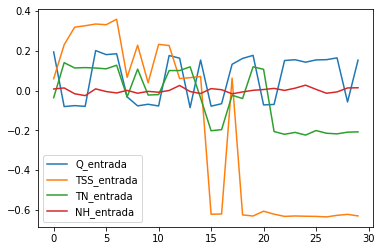

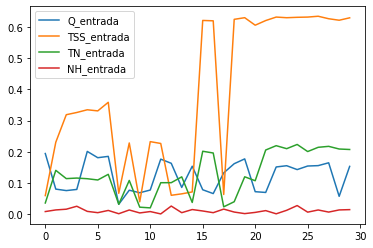

In [32]:
# df_lime_importances['TN'].plot()
df_lime_importances.plot()
df_lime_absolute_importances.plot()

### Análise de Feature Importance geral com LIME ao invés de apenas para ocorrência específica para a BASE DE TREINO

In [33]:
l=[]
for n in range(0,normalized_x_train.shape[0]):
     exp = explainer.explain_instance(normalized_x_train.values[n], rf_model_cv_gs.predict, num_features=X.shape[1])
     a=exp.as_list()
     l.append(a)


df_lime_train_importances = pd.DataFrame()
for sublist in l:
    row_values = {}
    for condition, value in sublist:
        match = re.search(r'([a-zA-Z_]+)', condition)
        if match:
            text = match.group(1)        
            row_values[text] = value
    df_lime_train_importances = df_lime_train_importances.append(row_values, ignore_index=True)

df_lime_train_importances

Intercept 0.1955450950080802
Prediction_local [-0.4997165]
Right: -0.8966817598058994
Intercept 0.19570182781653758
Prediction_local [-0.49005527]
Right: -0.9622805548534411
Intercept 0.1924657840729911
Prediction_local [-0.49677247]
Right: -0.9781389016055025
Intercept 0.1868390766775662
Prediction_local [-0.4946865]
Right: -0.9829517095497412
Intercept 0.19545182550235193
Prediction_local [-0.49546943]
Right: -0.9358212143223368
Intercept 0.19076560052470543
Prediction_local [-0.48365097]
Right: -0.9802021044118931
Intercept 0.2346118013682691
Prediction_local [-0.60877841]
Right: -0.830203473190504
Intercept 0.23976658042121957
Prediction_local [-0.63945123]
Right: -0.8448877397372597
Intercept 0.0013802603019138042
Prediction_local [0.09070101]
Right: -0.03984757083522635
Intercept 0.011139436601552654
Prediction_local [0.04454715]
Right: -0.2796396966298931
Intercept 0.19462001722117397
Prediction_local [-0.48764729]
Right: -0.493545235871884
Intercept 0.24433626200781622
Predicti

TSS_entrada  TN_entrada  Q_entrada  NH_entrada
0      -0.640962   -0.208437   0.161732   -0.007595
1      -0.635305   -0.224850   0.172782    0.001616
2      -0.627243   -0.208938   0.150457   -0.003514
3      -0.639305   -0.203733   0.154145    0.007367
4      -0.638682   -0.208290   0.160829   -0.004778
..           ...         ...        ...         ...
330     0.044289   -0.017360  -0.054848   -0.004831
331    -0.620586   -0.211931  -0.062988    0.022265
332    -0.629113   -0.204035   0.163736    0.017518
333     0.042622   -0.036157   0.179644   -0.011271
334     0.346612    0.110437  -0.064956    0.004499

[335 rows x 4 columns]

In [34]:
df_lime_train_absolute_importances = df_lime_train_importances.copy()

for i in range(df_lime_importances.shape[1]):
    df_lime_train_absolute_importances.iloc[:,i] = df_lime_train_absolute_importances.iloc[:,i].apply(lambda x: abs(float(x)))
     
df_lime_train_absolute_importances

TSS_entrada  TN_entrada  Q_entrada  NH_entrada
0       0.640962    0.208437   0.161732    0.007595
1       0.635305    0.224850   0.172782    0.001616
2       0.627243    0.208938   0.150457    0.003514
3       0.639305    0.203733   0.154145    0.007367
4       0.638682    0.208290   0.160829    0.004778
..           ...         ...        ...         ...
330     0.044289    0.017360   0.054848    0.004831
331     0.620586    0.211931   0.062988    0.022265
332     0.629113    0.204035   0.163736    0.017518
333     0.042622    0.036157   0.179644    0.011271
334     0.346612    0.110437   0.064956    0.004499

[335 rows x 4 columns]

In [35]:
df_lime_train_absolute_importances.mean()/df_lime_train_absolute_importances.mean().sum()

TSS_entrada    0.590301
TN_entrada     0.221145
Q_entrada      0.168499
NH_entrada     0.020055
dtype: float64

<Axes: >

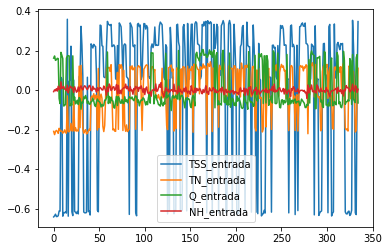

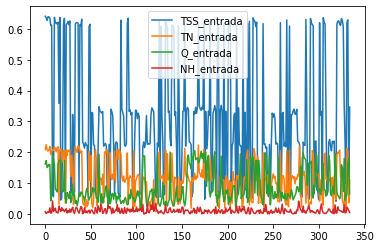

In [36]:
# df_lime_train_importances['TN'].plot()
df_lime_train_importances.plot()
df_lime_train_absolute_importances.plot()